# Glade vs. Stratus Performance for NA-CORDEX Zarr Stores

The [NA-CORDEX Visualization Cookbook](https://github.com/ProjectPythia/na-cordex-viz-cookbook/blob/main/notebooks/plot-diagnostics.ipynb) can use either NCAR's Glade filesystem or the Stratus Object Store as the repository for loading data.  We are interested in knowing more about how Glade and Stratus perform relative to each other when the notebook is run.   

In order to make sense of the comparison, we need to know a little more about the Notebook's access patterns, and how the Zarr Stores organize the data.


## Notebook Access Patterns

The notebook always loops over climate runs and focuses on producing plots for a single climate run at a time.   This pattern is not the most efficient because a chunk file usually contains four climate runs,  meaning that data from four climate runs is typically loaded each time, but only one of those runs is selected, and data from the other three runs is discarded.   While we could change the notebook to hold all four climate runs in memory once they are loaded, this would in practice mean that Dask workers would need up to 48 GB of RAM to handle plotting the largest of the Zarr stores, and this seemed less portable than requiring a smaller amount of RAM per worker and reloading values as needed.


The Visualization Cookbook produces three types of plots, each of which requires loading a portion of data from a Zarr store.   Below are the three types of the plots, with lists of the operations that require a *complete pass* through the output for a model run:


#### Plot First, Mid, Last Timesteps: __One Complete Pass__

This plot requires one complete pass through a climate run's output:

* Find time steps with valid data

Then it searches for min and max values within three timesteps, but this cost is negligible compared to a complete pass through the data.

![test](./tmax.day.eval.NAM-44i.raw_FML.png)


#### Produce Statistical Map Plot: Four Complete Passes

This plot requires four complete passes through the data:

* Find smallest value per grid cell
* Find largest value per grid cell 
* Find mean value per grid cell 
* Find standard deviation value per grid cell 

Then it searches for min and max values within the produced results, but this cost is negligible compared to a complete pass through the data.

![test](./tmax.day.eval.NAM-44i.raw_MAPS.png)


#### Produce Statistical Time Series Plot: Five Complete Passes

This plot requires five complete passes through the data:

* Find time steps with missing data
* Find smallest value per time step
* Find largest value per time step 
* Find mean value per time step 
* Find standard deviation value per time step 

![test](./tmax.day.eval.NAM-44i.raw_TS.png)




Below we plot the ratio of completion times for each type of plot.   In general, Stratus as a storage device is slower than Glade, so we produced the ratio: 

    (Stratus completion time) / (Glade completion time)


## Zarr Store Characteristics

Each Zarr store collects data from one climate variable, over many model runs, for a specific climate scenario or historical period.  More complete documentation can be found at the [NA-CORDEX documentation site](https://doi.org/10.26024/9xkm-fp81).

Zarr stores are organized as 4D data cubes broken into smaller, 4D chunk files.  Each chunk file, except those on the ragged edges of the data cube, have data for:

* 1000 daily timesteps
* 65   latitude values
* 120  longitude values
* 4    model runs

for around 31 million values per chunk file.   

### Example dataset:  Precipitation from 1980-2015

![test](./images/prec.day.eval.NAM-22i.png)

### Compression characteristics

Each chunk file is compressed using Blosc compression.   Below is a histogram showing chunk file sizes for Precipitation after compression.   Compression levels seem similar for other variables besides Precipitation.

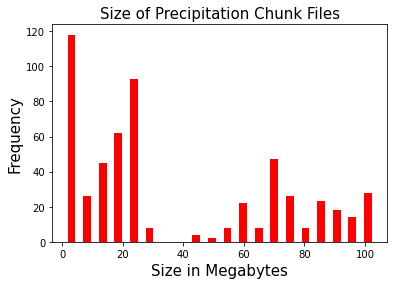

In [36]:
import numpy as np
from matplotlib import pyplot as plt

f = open('./data/sizes.prec.eval.NAM-22i.txt','r')
x = np.loadtxt(f)
x = x / 1000000.0
plt.hist(x, bins=20, histtype='bar',facecolor = 'red',  rwidth=0.5)
plt.xlabel('Size in Megabytes',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Size of Precipitation Chunk Files',fontsize=15)
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def make_plot(ratios, scenario):
    figWidth = 18 
    figHeight = 12 

    fig = plt.figure(figsize=(figWidth, figHeight))
    nWorkers = [4, 8, 16, 32]
    plt.plot(nWorkers,ratios[0],'x-', label='low compute')
    plt.plot(nWorkers,ratios[1],'+-', label='med compute')
    plt.plot(nWorkers,ratios[2],'o-', label='high compute')
    plt.xlabel('Number of Workers')
    plt.ylabel('(Stratus time) / (Glade time)')
    plt.title(f'Time to Completion Ratio for "{scenario}" scenario')
    plt.legend(loc='best')
    return fig

In [5]:
comparison = dict(stratus = [], glade = [])

In [6]:
data = dict(eval = comparison, hist = comparison)


### Data for "eval" scenario (35 years)

In [11]:
# data['eval']['stratus'] = [[228, 111, 71, 47], 
#                            [351,154,104,49.9],
#                            [523,221,116,64]]
data['eval']['stratus'] = [[218, 111, 67, 40], 
                           [351,154,104,49.9],
                           [523,221,116,64]]

In [12]:
# data['eval']['glade'] = [[73,43.5,30.2,20.8], 
#                            [182,110,59.2,34.8],
#                            [291,163,92,50.7]]
data['eval']['glade'] = [[90, 39, 28, 15], 
                           [182,110,59.2,34.8],
                           [291,163,92,50.7]]

In [13]:
# See if element-wise division is supported
ratio = np.divide(data['eval']['stratus'], data['eval']['glade'])
ratio

array([[2.42222222, 2.84615385, 2.39285714, 2.66666667],
       [1.92857143, 1.4       , 1.75675676, 1.43390805],
       [1.79725086, 1.35582822, 1.26086957, 1.26232742]])

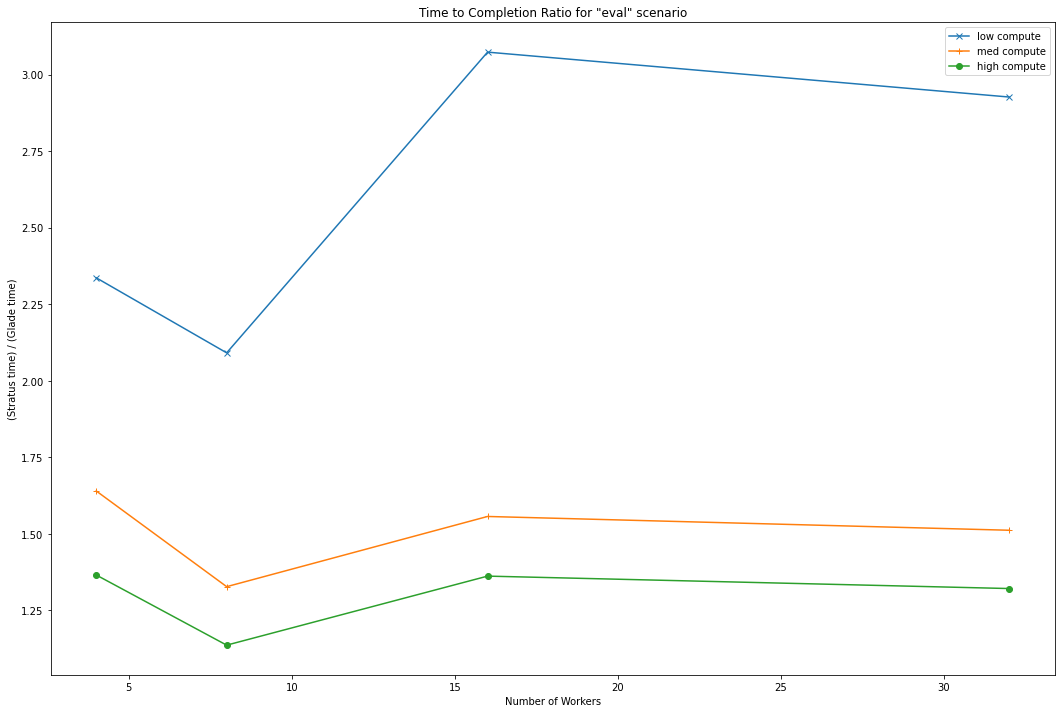

In [14]:
figure = make_plot(ratios, 'eval')
plt.show()

In [ ]:
np.transpose(ratio)

### Data for "hist" scenario (50 years)

In [ ]:
data['eval']['stratus'] = [[], 
                           [],
                           []]

In [ ]:
data['eval']['glade'] = [[], 
                           [],
                           []]

### Data for "rcp85" scenario (100 years)

In [ ]:
data['eval']['stratus'] = [[], 
                           [],
                           []]

In [ ]:
data['eval']['glade'] = [[], 
                           [],
                           []]

### Data for "hist-rcp85" scenario (150 years)

In [7]:
# data['eval']['stratus'] = [[700,363,205,128], 
#                            [1163,636,355,189],
#                            [1665,931,519,263]]
data['eval']['stratus'] = [[736, 412, 209, 120], 
                           [1163,636,355,189],
                           [1665,931,519,263]]

In [8]:
# data['eval']['glade'] = [[217,139,69,40.5], 
#                            [709,479,228,125],
#                            [1219,819,381,199]]
data['eval']['glade'] = [[315, 197, 68, 41], 
                           [709,479,228,125],
                           [1219,819,381,199]]

In [9]:
# See if element-wise division is supported
ratios = np.divide(data['eval']['stratus'], data['eval']['glade'])
ratios

array([[2.33650794, 2.09137056, 3.07352941, 2.92682927],
       [1.6403385 , 1.32776618, 1.55701754, 1.512     ],
       [1.36587367, 1.13675214, 1.36220472, 1.32160804]])

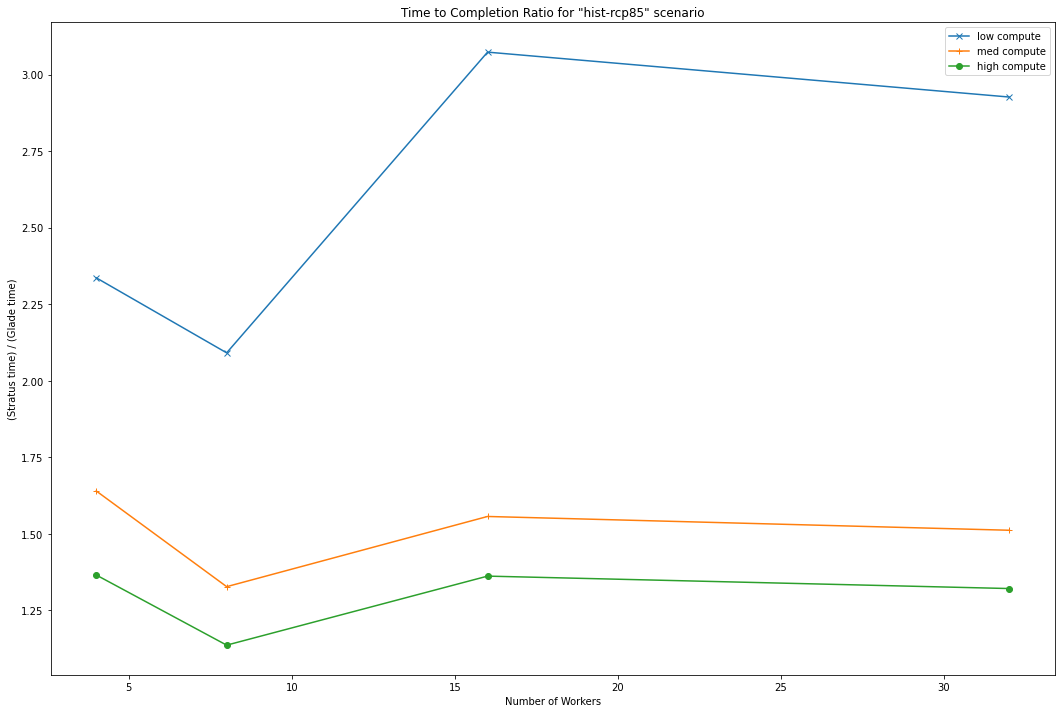

In [10]:
figure = make_plot(ratios, 'hist-rcp85')
plt.show()